# Dataset exploration

* [Annual mortality and causes by county, 1979-1988](https://www.cdc.gov/nchs/data_access/cmf.htm)
* [Compressed mortality info, 1968-2016](https://wonder.cdc.gov/controller/datarequest/D140)

[Rainfall and turnout](https://faculty.ucmerced.edu/thansford/Articles/The%20Republicans%20Should%20Pray%20for%20Rain%20-%20Weather,%20Turnour,%20and%20Voting%20in%20U.S.%20Presidential%20Elections.pdf)

[Higher temperatures increase suicide rates in the
United States and Mexico](https://web.stanford.edu/~mburke/papers/BurkeEtAl_NCC_2018.pdf)

As temperatures go up, suicide rates go up.
Heat waves, countries or regions that go through heat waves. During those times there were significant differences in suicide rates.

Is there monthly data?

[WHO mortality data](https://www.who.int/healthinfo/statistics/mortality_rawdata/en/)

[CDC Multiple Mortality Cause files](https://www.cdc.gov/nchs/data_access/vitalstatsonline.htm#Mortality_Multiple)

[Suicides and gun ownership](https://mason.gmu.edu/~atabarro/BriggsTabarrokFirearmsSuicide.pdf)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Suicides by Month, Year, State

`suicides.txt` from https://wonder.cdc.gov/wonder/help/mcd.html, restricted to suicides
* https://wonder.cdc.gov/mcd-icd10.html
* Click Agree
* https://wonder.cdc.gov/controller/datarequest/D77
* Group results by State, Year, Month
* Ages exclude "Not stated"; Hispanic Origin exclude "Not stated"
* Underlying cause of death: X60-X84 (Intentional self-harm)

In [15]:
suicides = pd.read_csv('suicides_heat.csv')
suicides.describe()

,Unnamed: 0,State Code,Year,Year Code,Month,Deaths,Population,Crude Rate,avg_max_t,avg_min_t,avg_max_heat_index,min_t_diff,max_t_diff,heat_index_diff
count,6749.000000,6749.000000,6749.000000,6749.000000,6749.000000,6749.000000,6.749000e+03,6749.000000,6749.000000,6749.000000,4463.000000,6.749000e+03,6.749000e+03,4.463000e+03
mean,3374.000000,29.207290,2005.071122,2005.071122,6.491184,62.935101,6.686066e+06,1.074396,63.157389,45.656300,86.587356,1.430508e-16,-5.822050e-16,1.832875e-16
std,1948.412816,15.036101,3.752294,3.752294,3.447479,55.388777,6.624632e+06,0.354648,18.824764,16.579405,5.258996,2.789689e+00,3.327905e+00,1.924380e+00
min,0.000000,1.000000,1999.000000,1999.000000,1.000000,10.000000,4.917800e+05,0.326515,10.210000,-5.860000,78.250000,-1.589308e+01,-1.445818e+01,-8.457692e+00
25%,1687.000000,18.000000,2002.000000,2002.000000,4.000000,29.000000,2.724816e+06,0.839194,49.070000,33.210000,82.710000,-1.736923e+00,-2.159231e+00,-1.172637e+00
50%,3374.000000,29.000000,2005.000000,2005.000000,6.000000,47.000000,4.720423e+06,1.027136,65.090000,45.650000,85.450000,-8.384615e-02,-1.384615e-02,-1.269231e-01
75%,5061.000000,41.000000,2008.000000,2008.000000,9.000000,77.000000,8.096604e+06,1.241495,78.610000,59.080000,89.390000,1.759231e+00,2.173077e+00,9.830769e-01
max,6748.000000,56.000000,2011.000000,2011.000000,12.000000,376.000000,3.769191e+07,4.048170,106.210000,79.510000,108.440000,1.473538e+01,1.401077e+01,9.100769e+00


# Exploratory Data Analysis

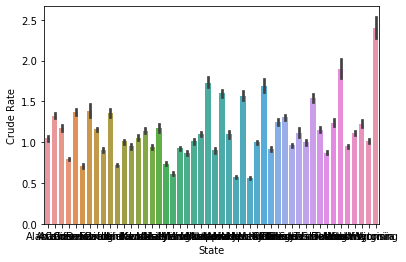

In [3]:
sns.barplot(x='State', y='Crude Rate', data=suicides)

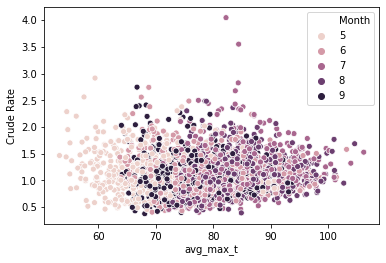

In [4]:
sns.scatterplot(x='avg_max_t', y='Crude Rate',  data=suicides.query('4 < Month < 10'), hue='Month', legend='full')

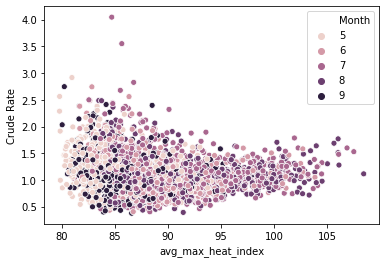

In [5]:
sns.scatterplot(x='avg_max_heat_index', 
                y='Crude Rate', data=suicides.query('4 < Month < 10'), hue='Month', legend='full')

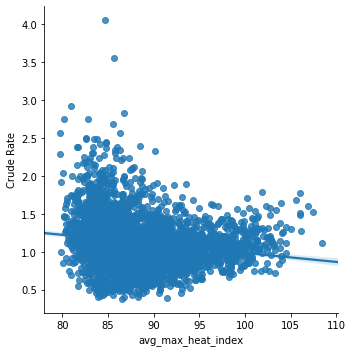

In [6]:
sns.lmplot(x='avg_max_heat_index', 
                y='Crude Rate', data=suicides.query('4 < Month < 10'), legend='full')

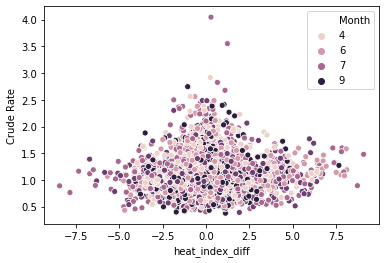

In [7]:
sns.scatterplot(x='heat_index_diff', y='Crude Rate', data=suicides.query('4 < Month < 10'), hue='Month')

What if we compare when heat_index diff > 5 to when heat_index diff < 5

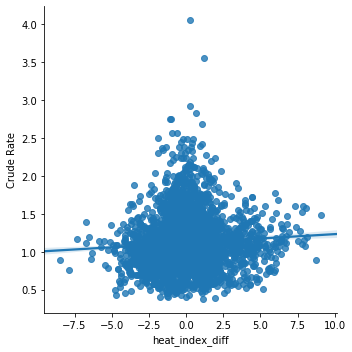

In [8]:
sns.lmplot(x='heat_index_diff', y='Crude Rate', data=suicides.query('4 < Month < 10'))

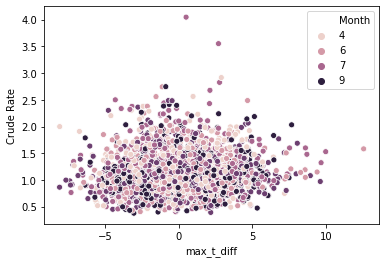

In [9]:
sns.scatterplot(x='max_t_diff', y='Crude Rate', data=suicides.query('4 < Month < 10'), hue='Month')

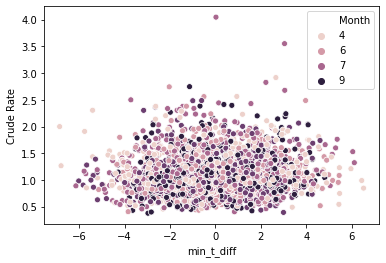

In [10]:
sns.scatterplot(x='min_t_diff', y='Crude Rate', data=suicides.query('4 < Month < 10'), hue='Month')

There may be a time effect over the years!

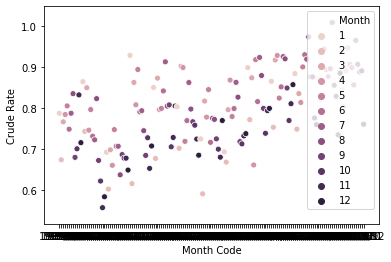

In [11]:
sns.scatterplot(x='Month Code', y='Crude Rate', data=suicides[suicides.State == 'California'],hue='Month', legend='full')

There is a strong annual trend.

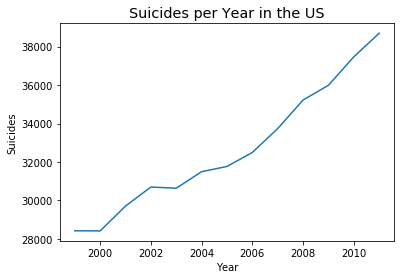

In [19]:
plt.plot(suicides.groupby('Year').sum().Deaths)
plt.style.use('ggplot')
plt.xlabel('Year')
plt.ylabel('Suicides')
plt.title('Suicides per Year in the US');

Chi-squared tells us whether two categorical variables are independent


understand occurences with one object and many factors
chi-squared test
```
                 99   | 00   | 01    | 02 | 03 ... 17
AL suicides      sum    sum    sum    sum   sum ...
CA 
CO
...
```

In [13]:
in summer months: categorical variable low heat,  high heat 

SyntaxError: invalid syntax (<ipython-input-13-e89acbf54951>, line 1)

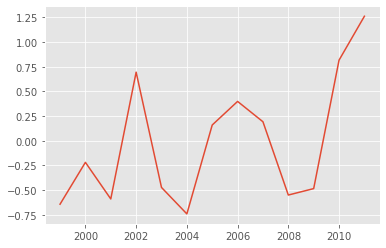

In [25]:
plt.plot(suicides.groupby('Year').mean()['heat_index_diff'])
plt.style.use('ggplot')
# plt.xlabel('Year')
# plt.ylabel('heat index diff')
# plt.title('heat index diff Year in the US');

## Hypothesis 1 - winter gets more suicides than summer

In [28]:
summer = suicides.query('5 < Month < 9')
winter = suicides.query('Month < 4 or Month > 10')
spring = suicides.query('3 < Month < 6')
longsummer = suicides.query('3 < Month < 9')
fall = suicides.query('8 < Month < 11')

In [ ]:
plt.hist(longsummer['Crude Rate'], bins='auto', alpha=.5, label='April-August')
plt.hist(winter['Crude Rate'], bins='auto', alpha=.5, label='November-March')
# plt.hist(fall.suicide_rate, bins='auto', alpha=.5, label='September-October')
plt.legend()

In [ ]:
stats.ttest_ind(winter['Crude Rate'], longsummer['Crude Rate'], equal_var=False)

In [ ]:
# Cohen's d
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

cohen_d(winter['Crude Rate'], longsummer['Crude Rate'])

## Let's cancel out year effect

In [14]:
# mean out the years
# observations are states
# group by states mean of rate by month
suicides_by_month = suicides.groupby(['Month',
                  'State']).agg('mean').reset_index() \
                .drop(columns=['Year','Year Code','min_t_diff', 'max_t_diff'])
suicides_by_month

,Month,State,Unnamed: 0,State Code,Deaths,Population,Crude Rate,avg_max_t,avg_min_t,avg_max_heat_index,heat_index_diff
0,1,Alabama,72.000000,1.0,51.692308,4.599187e+06,1.121179,54.712308,35.743077,82.570000,7.105427e-15
1,1,Arizona,228.000000,4.0,77.692308,5.809299e+06,1.337000,51.595385,35.239231,79.032000,2.842171e-15
2,1,Arkansas,384.000000,5.0,31.461538,2.790312e+06,1.127626,50.200769,32.541538,81.796667,0.000000e+00
3,1,California,540.000000,6.0,294.615385,3.570468e+07,0.824524,51.926154,37.538462,79.385000,-1.847411e-14
4,1,Colorado,696.000000,8.0,68.230769,4.670093e+06,1.457071,34.466923,19.360769,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
569,12,Virginia,6155.000000,51.0,63.692308,7.558874e+06,0.839192,45.456154,30.516923,NaN,NaN
570,12,Washington,6311.000000,53.0,68.000000,6.302415e+06,1.078010,36.582308,27.504615,NaN,NaN
571,12,West Virginia,6467.000000,54.0,22.230769,1.825744e+06,1.217424,40.626154,27.683846,NaN,NaN
572,12,Wisconsin,6623.000000,55.0,53.307692,5.537321e+06,0.961193,26.812308,15.025385,NaN,NaN


Paired t-test. Compare the sum of the months against the mean of the months

In [ ]:
summer_by_month = suicides_by_month.query('3 < Month < 9')
winter_by_month = suicides_by_month.query('Month < 4 or Month > 10')

In [ ]:
summer_by_month.groupby('State').mean()['Crude Rate']

In [ ]:
stats.ttest_rel(summer_by_month.groupby('State').mean()['Crude Rate'], 
                winter_by_month.groupby('State').mean()['Crude Rate'])

In [ ]:
cohen_d(summer_by_month.groupby('State').mean()['Crude Rate'], 
        winter_by_month.groupby('State').mean()['Crude Rate'])

In [ ]:
stats.ttest_rel(summer_by_month.groupby('State').sum()['Crude Rate'], 
                winter_by_month.groupby('State').sum()['Crude Rate'])

In [ ]:
cohen_d(summer_by_month.groupby('State').sum()['Crude Rate'], 
        winter_by_month.groupby('State').sum()['Crude Rate'])

Nope, in fact spring & summer are worse than winter!

In [ ]:
sns.distplot(suicides.query('3 < Month < 9').avg_max_heat_index.dropna())

In [ ]:
sns.distplot(suicides.query('3 < Month < 9').heat_index_diff.dropna())

In [ ]:
q_75 = np.quantile(suicides.query('3 < Month < 9').avg_max_heat_index.dropna(), .75)
q_75

In [ ]:
q_95 = np.quantile(suicides.query('3 < Month < 9').avg_max_heat_index.dropna(), .95)
q_95

In [ ]:
q_05 = np.quantile(suicides.query('3 < Month < 9').avg_max_heat_index.dropna(), .05)
q_05

In [ ]:
low_heat = longsummer.query(f'avg_max_heat_index < {q_75}')
high_heat = longsummer.query(f'avg_max_heat_index > {q_95}')
stats.ttest_ind(low_heat['Crude Rate'], high_heat['Crude Rate'], equal_var=False)

In [ ]:
q_diff_75 = np.quantile(suicides.query('3 < Month < 9').heat_index_diff.dropna(), .75)
q_diff_75

In [ ]:
q_diff_95 = np.quantile(suicides.query('3 < Month < 9').heat_index_diff.dropna(), .95)
q_diff_95

In [ ]:
suicides.query('3 < Month < 9').groupby('Year').avg_max_heat_index.hist(alpha=.25, bins='auto')

In [ ]:
suicides.query('3 < Month < 9').groupby('Year').heat_index_diff.hist(alpha=.25, bins='auto')

In [ ]:
sns.distplot(suicides.query('3 < Month < 9').heat_index_diff.dropna())

In [ ]:
np.quantile(suicides.query('3 < Month < 9').heat_index_diff.dropna(),.25)

# SUMMER - LOW/MED/HIGH HEAT BY STATE


In [ ]:
longsummer.query('State =="New York"').describe()

In [ ]:
summer_by_month.query('State =="New York"')

In [ ]:
summer_by_month.groupby(['State','heat_index_level']).agg('mean').reset_index()

In [ ]:
def heat_category(temp, low, high):
    if temp <= low:
        return 'low heat'
    if temp >= high:
        return 'high heat'
    return 'medium heat'

summer_by_month['heat_index_level'] = summer_by_month['avg_max_heat_index'].map(lambda x: heat_category(x, q_05, q_95))
summer_by_month

In [ ]:
summer_by_month

In [ ]:
suicides_by_state_and_heat = pd.pivot_table(summer_by_month, index='State', values='Deaths', 
                                            columns='heat_index_level', aggfunc=np.mean)
suicides_by_state_and_heat

In [ ]:
summer_by_month = summer_by_month.dropna()
summer_by_month.info()

In [ ]:
summer_by_month.groupby(['State']).count()

In [ ]:
suicides.groupby(['State','Year']).sum().reset_index()

In [ ]:
from statsmodels.stats.anova import AnovaRM

anovrm_1 = AnovaRM(suicides.groupby(['State','Year']).sum().reset_index(), 'Deaths', 'State', within=['Year'], aggregate_func=np.mean)
res = anovrm_1.fit()

print(res)

In [26]:
east_99 = ['Maryland', 'Delaware', 'New Jersey', 'Rhode Island', 'West Virginia']

In [32]:
longsummer[longsummer.State.isin(east_99) & (longsummer.Year == 1999)]

,Unnamed: 0,State,State Code,Year,Year Code,Month,Month Code,Deaths,Population,Crude Rate,avg_max_t,avg_min_t,avg_max_heat_index,min_t_diff,max_t_diff,heat_index_diff
936,936,Delaware,10.0,1999.0,1999.0,7,1999/07,13.0,774990.0,1.677441,86.46,70.41,94.28,0.690000,2.565000,3.957500
937,937,Delaware,10.0,1999.0,1999.0,8,1999/08,12.0,774990.0,1.548407,84.33,69.14,89.78,-1.024286,-0.230000,-0.814286
2517,2517,Maryland,24.0,1999.0,1999.0,4,1999/04,38.0,5254509.0,0.723188,59.81,41.58,82.14,-2.901538,-1.885385,-0.565833
2518,2518,Maryland,24.0,1999.0,1999.0,5,1999/05,36.0,5254509.0,0.685126,70.06,51.06,83.93,-1.827692,-0.149231,-1.976154
2519,2519,Maryland,24.0,1999.0,1999.0,6,1999/06,37.0,5254509.0,0.704157,77.08,60.19,88.45,-2.680000,-1.949231,-0.900769
2520,2520,Maryland,24.0,1999.0,1999.0,7,1999/07,33.0,5254509.0,0.628032,87.91,69.39,94.49,1.683846,4.036923,4.061538
2521,2521,Maryland,24.0,1999.0,1999.0,8,1999/08,41.0,5254509.0,0.780282,84.35,66.39,89.19,-1.309231,0.595385,-0.896154
4032,4032,New Jersey,34.0,1999.0,1999.0,4,1999/04,42.0,8359592.0,0.502417,57.72,39.77,NaN,-2.450000,-1.951538,NaN
4033,4033,New Jersey,34.0,1999.0,1999.0,5,1999/05,46.0,8359592.0,0.550266,68.24,49.29,84.11,-1.513846,-0.450769,-1.826364
4034,4034,New Jersey,34.0,1999.0,1999.0,6,1999/06,47.0,8359592.0,0.562228,76.71,59.04,89.57,-2.094615,-0.989231,0.391538
